In [52]:
!pip install plotly

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
import pandas as pd
import numpy as np
# Visualize
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SVMSMOTE

# Scikit-learn models
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

TEST_PERCENT = 0.2
VAL_PERCENT = 0

def plot_cm(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['1', '0'])

## 1. Read Data

In [55]:
# Load data
df = pd.read_csv("Data/credit_risk_dataset.csv")
print(df.shape)
print(df['loan_status'].value_counts(normalize=True))

(32581, 12)
0    0.781836
1    0.218164
Name: loan_status, dtype: float64


In [56]:
df.head(10)

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   
6          26          77100                  RENT                8.0   
7          24          78956                  RENT                5.0   
8          24          83000                  RENT                8.0   
9          21          10000                   OWN                6.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   
5     VENTURE          A       2500           7.14            1   
6   EDUCATION          B      35000          12.42            1   
7     MEDICAL          B      35000          11.11            1   
8    PERSONAL          A      35000           8.90            1   
9     VENTURE          D       1600          14.74            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4  
5                 0.25                         N                           2  
6                 0.45                         N                           3  
7                 0.44                         N                           4  
8                 0.42                         N                           2  
9                 0.16                         N                           3

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [58]:
# Continuous variable
df.describe(exclude='O')

person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

In [59]:
# Category variable
df.select_dtypes(include='O').describe()

person_home_ownership loan_intent loan_grade cb_person_default_on_file
count                  32581       32581      32581                     32581
unique                     4           6          7                         2
top                     RENT   EDUCATION          A                         N
freq                   16446        6453      10777                     26836

## 2. Pre-Processing

### 2.1. Outlier

In [60]:
# Scatterplot matrix
continuous_variable_columns = df.select_dtypes(exclude='O').columns.difference(['loan_status'])
fig = px.scatter_matrix(df, dimensions=continuous_variable_columns, width=1350, height=1150, color="loan_status", color_continuous_scale=px.colors.diverging.Geyser)
fig.show()

In [61]:
# Removing outliers
df = df[df['person_age'] <= 100]
df = df[df['person_emp_length'] <= 100]
df = df[df['person_income'] <= 2000000]
df.reset_index(drop=True, inplace=True)

In [62]:
df.shape

(31678, 12)

### 2.2. Missing value

In [63]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3047
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [64]:
# Fill missing values with means of same label samples in a column
df_0 = df.loan_status == 0
df_1 = df.loan_status == 1

values_0 = {'loan_int_rate': df.loc[df_0, 'loan_int_rate'].mean()}
values_1 = {'loan_int_rate': df.loc[df_1, 'loan_int_rate'].mean()}

df.loc[df_0] = df.loc[df_0].fillna(values_0)
df.loc[df_1] = df.loc[df_1].fillna(values_1)

In [65]:
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### 2.3. Feature Selection

<AxesSubplot:>

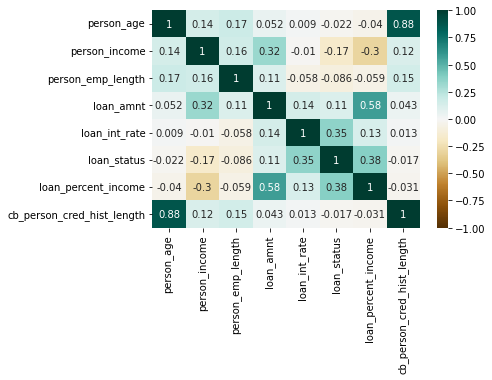

In [66]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="BrBG")

<AxesSubplot:xlabel='cb_person_cred_hist_length', ylabel='person_age'>

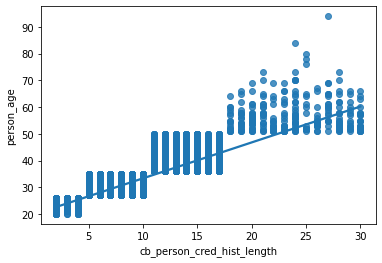

In [67]:
# Check linear relationship
sns.regplot(x='cb_person_cred_hist_length', y='person_age', data=df)

In [68]:
df = df.drop('cb_person_cred_hist_length', axis=1)

### 2.4. Transformation

In [69]:
#Parallel category diagram
categories_variable_columns = df.select_dtypes(include='O').columns
fig = px.parallel_categories(df, dimensions=categories_variable_columns, width=1000, height=600, color="loan_status", color_continuous_scale=px.colors.diverging.Geyser)
fig.show()

In [70]:
for value in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    print(value, end=": ")
    print(df.loc[df['loan_grade'] == value, 'loan_status'].value_counts(normalize=True)[0])

A: 0.9044358727097397
B: 0.8407149170185604
C: 0.7969294080405191
D: 0.4123769338959212
E: 0.3581932773109244
F: 0.2966101694915254
G: 0.015625


In [71]:
df['loan_grade'].replace({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}, inplace = True)
df['loan_grade'].astype('int64')

df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace = True)
df['cb_person_default_on_file'].astype('int64')

# One hot encoding of other categorical variables
df = pd.get_dummies(data=df, columns=df.select_dtypes(include='O').columns)

In [72]:
print(df.shape)
df

(31678, 19)


person_age  person_income  person_emp_length  loan_grade  loan_amnt  \
0              21           9600                5.0           2       1000   
1              25           9600                1.0           3       5500   
2              23          65500                4.0           3      35000   
3              24          54400                8.0           3      35000   
4              21           9900                2.0           1       2500   
...           ...            ...                ...         ...        ...   
31673          57          53000                1.0           3       5800   
31674          54         120000                4.0           1      17625   
31675          65          76000                3.0           2      35000   
31676          56         150000                5.0           2      15000   
31677          66          42000                2.0           2       6475   

       loan_int_rate  loan_status  loan_percent_income  \
0              11.14            0                 0.10   
1              12.87            1                 0.57   
2              15.23            1                 0.53   
3              14.27            1                 0.55   
4               7.14            1                 0.25   
...              ...          ...                  ...   
31673          13.16            0                 0.11   
31674           7.49            0                 0.15   
31675          10.99            1                 0.46   
31676          11.48            0                 0.10   
31677           9.99            0                 0.15   

       cb_person_default_on_file  person_home_ownership_MORTGAGE  \
0                              0                               0   
1                              0                               1   
2                              0                               0   
3                              1                               0   
4                              0                               0   
...                          ...                             ...   
31673                          0                               1   
31674                          0                               1   
31675                          0                               0   
31676                          0                               1   
31677                          0                               0   

       person_home_ownership_OTHER  person_home_ownership_OWN  \
0                                0                          1   
1                                0                          0   
2                                0                          0   
3                                0                          0   
4                                0                          1   
...                            ...                        ...   
31673                            0                          0   
31674                            0                          0   
31675                            0                          0   
31676                            0                          0   
31677                            0                          0   

       person_home_ownership_RENT  loan_intent_DEBTCONSOLIDATION  \
0                               0                              0   
1                               0                              0   
2                               1                              0   
3                               1                              0   
4                               0                              0   
...                           ...                            ...   
31673                           0                              0   
31674                           0                              0   
31675                           1                              0   
31676                           0                              0   
31677                      

## 3. Training

In [73]:
# Split dataset
y = df['loan_status']
X = df.drop('loan_status', axis=1)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=(TEST_PERCENT+VAL_PERCENT), random_state=2)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=TEST_PERCENT, random_state=3)
print(y_train.value_counts())
print(y_test.value_counts())

0    19891
1     5451
Name: loan_status, dtype: int64
0    3963
1    1105
Name: loan_status, dtype: int64


In [74]:
# Init Model
model_nb = GaussianNB()
model_lr = LogisticRegression(C=1)
model_dt = DecisionTreeClassifier(max_leaf_nodes=20)

In [75]:
model_nb.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=20)

## 4. Testing

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3963
           1       0.66      0.38      0.48      1105

    accuracy                           0.82      5068
   macro avg       0.75      0.66      0.69      5068
weighted avg       0.81      0.82      0.80      5068



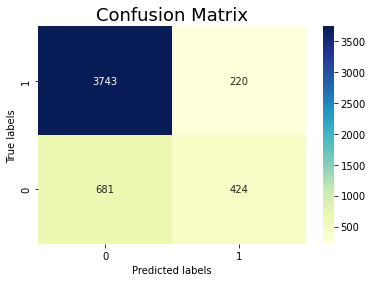

In [76]:
predicts_nb = model_nb.predict(X_test)
print(classification_report(y_test, predicts_nb))
plot_cm(metrics.confusion_matrix(y_test, predicts_nb))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3963
           1       0.70      0.18      0.28      1105

    accuracy                           0.80      5068
   macro avg       0.75      0.58      0.58      5068
weighted avg       0.78      0.80      0.75      5068



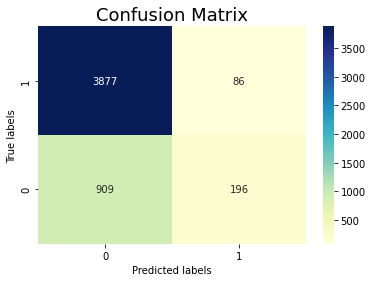

In [77]:
predicts_lr = model_lr.predict(X_test)
print(classification_report(y_test, predicts_lr))
plot_cm(metrics.confusion_matrix(y_test, predicts_lr))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3963
           1       0.97      0.71      0.82      1105

    accuracy                           0.93      5068
   macro avg       0.95      0.85      0.89      5068
weighted avg       0.94      0.93      0.93      5068



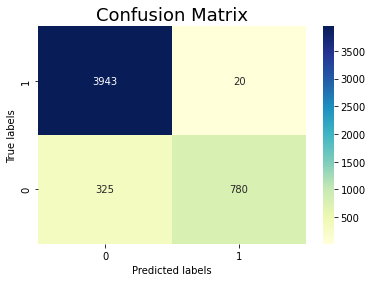

In [78]:
predicts_dt = model_dt.predict(X_test)
print(classification_report(y_test, predicts_dt))
plot_cm(metrics.confusion_matrix(y_test, predicts_dt))

## 5. Improve Quality

### 5.1. Oversampling

              precision    recall  f1-score   support

           0       0.91      0.67      0.77      3963
           1       0.39      0.76      0.52      1105

    accuracy                           0.69      5068
   macro avg       0.65      0.71      0.64      5068
weighted avg       0.80      0.69      0.72      5068



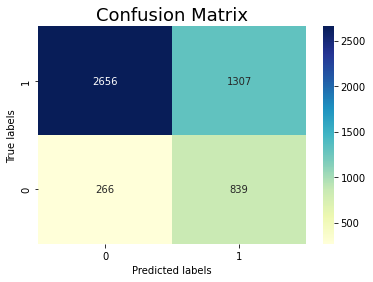

In [79]:
sampler = SVMSMOTE(sampling_strategy = 1, random_state=0)

pipeline_nb = make_pipeline(sampler, model_nb)
pipeline_nb.fit(X_train, y_train)
predicts_nb = model_nb.predict(X_test)
print(classification_report(y_test, predicts_nb))
plot_cm(metrics.confusion_matrix(y_test, predicts_nb))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      3963
           1       0.42      0.78      0.54      1105

    accuracy                           0.71      5068
   macro avg       0.67      0.74      0.67      5068
weighted avg       0.81      0.71      0.74      5068



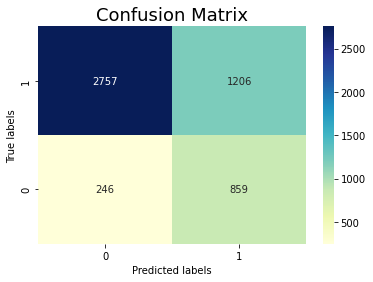

In [80]:
sampler = SVMSMOTE(sampling_strategy = 1, random_state=0)

pipeline_lr = make_pipeline(sampler, model_lr)
pipeline_lr.fit(X_train, y_train)
predicts_lr = model_lr.predict(X_test)
print(classification_report(y_test, predicts_lr))
plot_cm(metrics.confusion_matrix(y_test, predicts_lr))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3963
           1       0.74      0.72      0.73      1105

    accuracy                           0.88      5068
   macro avg       0.83      0.83      0.83      5068
weighted avg       0.88      0.88      0.88      5068



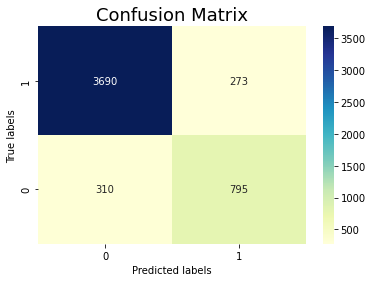

In [81]:
sampler = SVMSMOTE(sampling_strategy = 1, random_state=0)

pipeline_dt = make_pipeline(sampler, model_dt)
pipeline_dt.fit(X_train, y_train)
predicts_dt = model_dt.predict(X_test)
print(classification_report(y_test, predicts_dt))
plot_cm(metrics.confusion_matrix(y_test, predicts_dt))

### 5.2. Change threshold classify

              precision    recall  f1-score   support

           0       0.93      0.39      0.55      3963
           1       0.29      0.90      0.44      1105

    accuracy                           0.50      5068
   macro avg       0.61      0.65      0.50      5068
weighted avg       0.79      0.50      0.53      5068



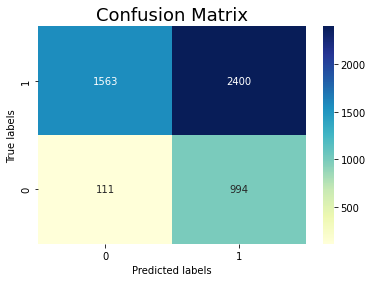

In [82]:
rs = pd.DataFrame()
rs['predict_probs_nb'] = model_nb.predict_proba(X_test)[:, 1]
rs['predicts_nb'] = rs['predict_probs_nb'].apply(lambda el: 1 if el >= 0.3 else 0)
print(classification_report(y_test, rs['predicts_nb']))
plot_cm(metrics.confusion_matrix(y_test, rs['predicts_nb']))

              precision    recall  f1-score   support

           0       0.94      0.46      0.62      3963
           1       0.32      0.90      0.47      1105

    accuracy                           0.56      5068
   macro avg       0.63      0.68      0.55      5068
weighted avg       0.81      0.56      0.59      5068



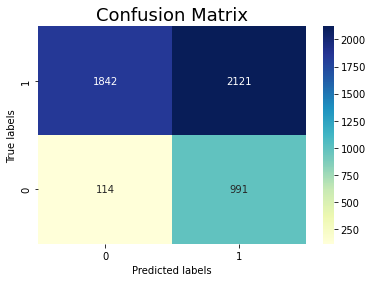

In [83]:
rs = pd.DataFrame()
rs['predict_probs_lr'] = model_lr.predict_proba(X_test)[:, 1]
rs['predicts_lr'] = rs['predict_probs_lr'].apply(lambda el: 1 if el >= 0.32 else 0)
print(classification_report(y_test, rs['predicts_lr']))
plot_cm(metrics.confusion_matrix(y_test, rs['predicts_lr']))

              precision    recall  f1-score   support

           0       0.96      0.62      0.76      3963
           1       0.40      0.90      0.56      1105

    accuracy                           0.69      5068
   macro avg       0.68      0.76      0.66      5068
weighted avg       0.84      0.69      0.71      5068



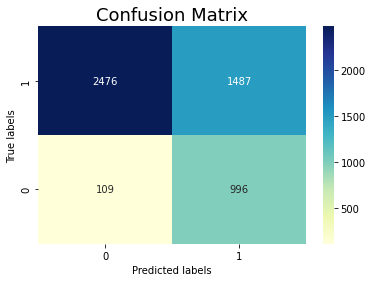

In [84]:
rs = pd.DataFrame()
rs['predict_probs_dt'] = model_dt.predict_proba(X_test)[:, 1]
rs['predicts_dt'] = rs['predict_probs_dt'].apply(lambda el: 1 if el >= 0.29 else 0)
print(classification_report(y_test, rs['predicts_dt']))
plot_cm(metrics.confusion_matrix(y_test, rs['predicts_dt']))

## 6. Hyperparameters Tuning

### 6.1. Logistic Regression

In [85]:
c_values = [10**i for i in range(-3, 4)]
grid = dict(C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val, y_val)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/home/hoang/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hoang/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Best: 0.831215 using {'C': 1}
0.823303 (0.018124) with: {'C': 0.001}
0.829628 (0.019911) with: {'C': 0.01}
0.830427 (0.017830) with: {'C': 0.1}
0.831215 (0.017825) with: {'C': 1}
0.830421 (0.018238) with: {'C': 10}
0.830421 (0.018238) with: {'C': 100}
0.830421 (0.018238) with: {'C': 1000}


### 6.2. Decision Tree

In [86]:
max_leaf_nodes_values = [i for i in range(1, 25)]
grid = dict(max_leaf_nodes=max_leaf_nodes_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val, y_val)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/home/hoang/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
Traceback (most recent call last):
  File "/home/hoang/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/hoang/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/home/hoang/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 294, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/hoang/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this t

Best: 0.914842 using {'max_leaf_nodes': 20}
0.000000 (0.000000) with: {'max_leaf_nodes': 1}
0.839858 (0.025021) with: {'max_leaf_nodes': 2}
0.863536 (0.037557) with: {'max_leaf_nodes': 3}
0.880909 (0.028302) with: {'max_leaf_nodes': 4}
0.886439 (0.025921) with: {'max_leaf_nodes': 5}
0.888020 (0.024840) with: {'max_leaf_nodes': 6}
0.888801 (0.028299) with: {'max_leaf_nodes': 7}
0.893538 (0.023404) with: {'max_leaf_nodes': 8}
0.902993 (0.026632) with: {'max_leaf_nodes': 9}
0.903793 (0.027438) with: {'max_leaf_nodes': 10}
0.905362 (0.025149) with: {'max_leaf_nodes': 11}
0.909286 (0.032194) with: {'max_leaf_nodes': 12}
0.907724 (0.029904) with: {'max_leaf_nodes': 13}
0.906937 (0.029639) with: {'max_leaf_nodes': 14}
0.913255 (0.029656) with: {'max_leaf_nodes': 15}
0.910092 (0.029719) with: {'max_leaf_nodes': 16}
0.910092 (0.029719) with: {'max_leaf_nodes': 17}
0.911686 (0.030216) with: {'max_leaf_nodes': 18}
0.910899 (0.029433) with: {'max_leaf_nodes': 19}
0.914842 (0.027188) with: {'max_le

## 7. Evaluation

### 7.1. ROC-AUC

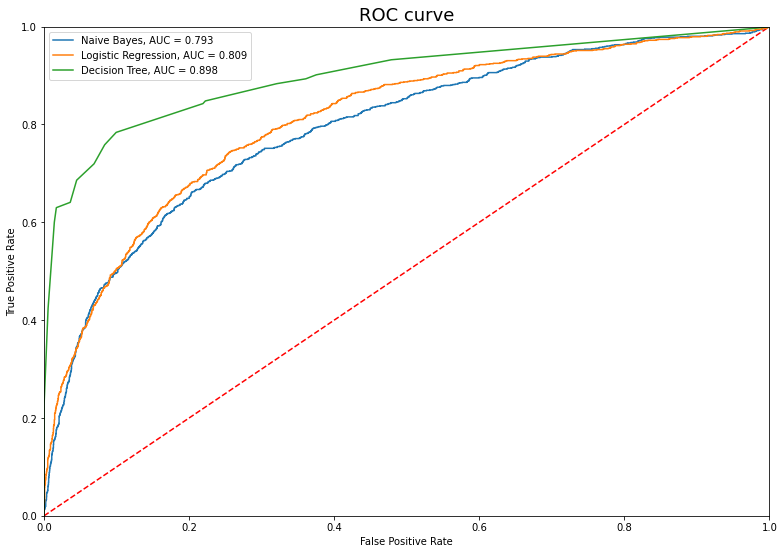

In [87]:
fig = plt.figure(figsize=(13,9))
plt.plot([0, 1], [0, 1],'r--')

predict_pobs_nb = model_nb.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, predict_pobs_nb)
auc = metrics.roc_auc_score(y_test, predict_pobs_nb)
plt.plot(fpr, tpr, label=f'Naive Bayes, AUC = {str(round(auc,3))}')

predict_pobs_lr = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, predict_pobs_lr)
auc = metrics.roc_auc_score(y_test, predict_pobs_lr)
plt.plot(fpr, tpr, label=f'Logistic Regression, AUC = {str(round(auc,3))}')

predict_pobs_dt = model_dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = metrics.roc_curve(y_test, predict_pobs_dt)
auc = metrics.roc_auc_score(y_test, predict_pobs_dt)
plt.plot(fpr, tpr, label=f'Decision Tree, AUC = {str(round(auc,3))}')

# Plot
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### 7.2. Feature Importance

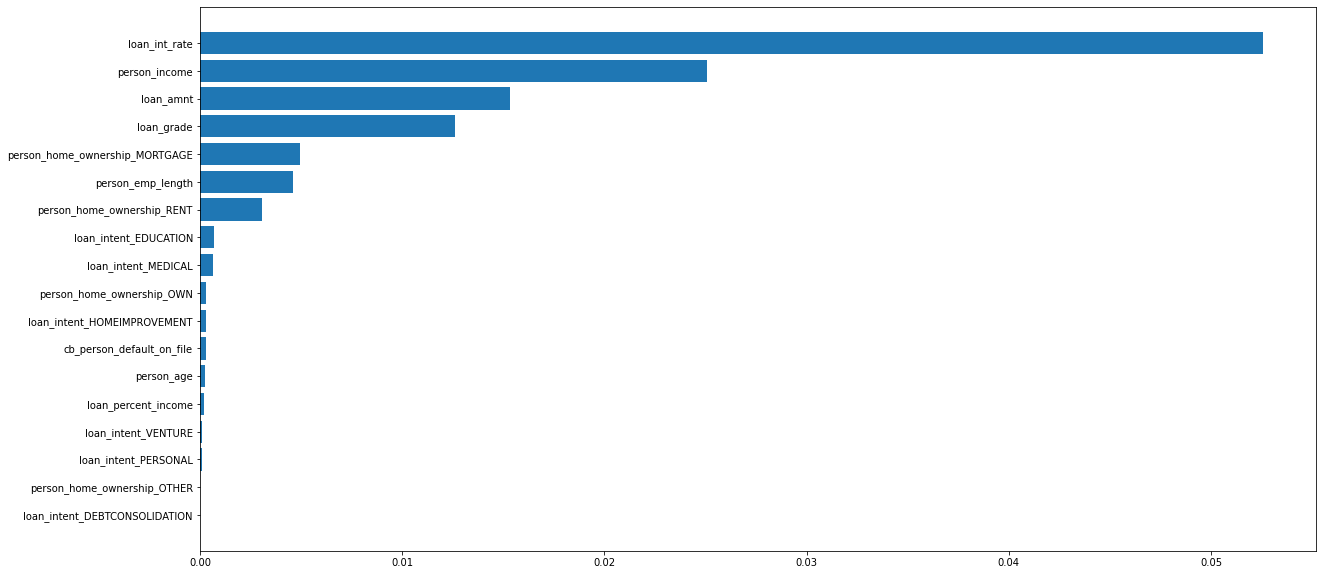

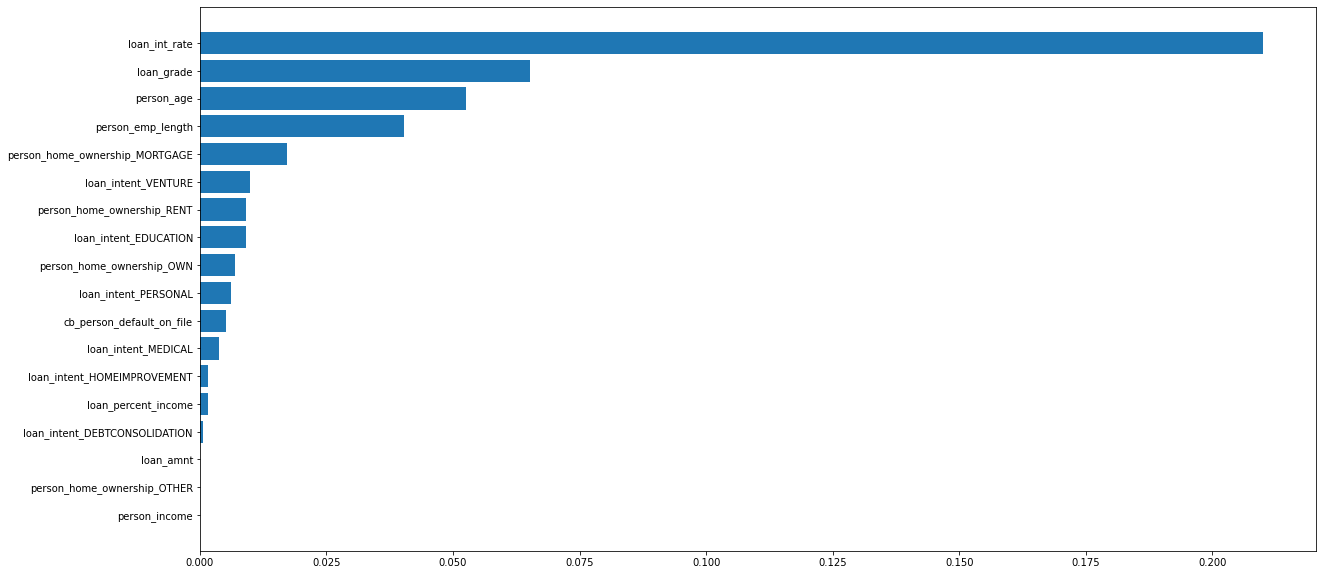

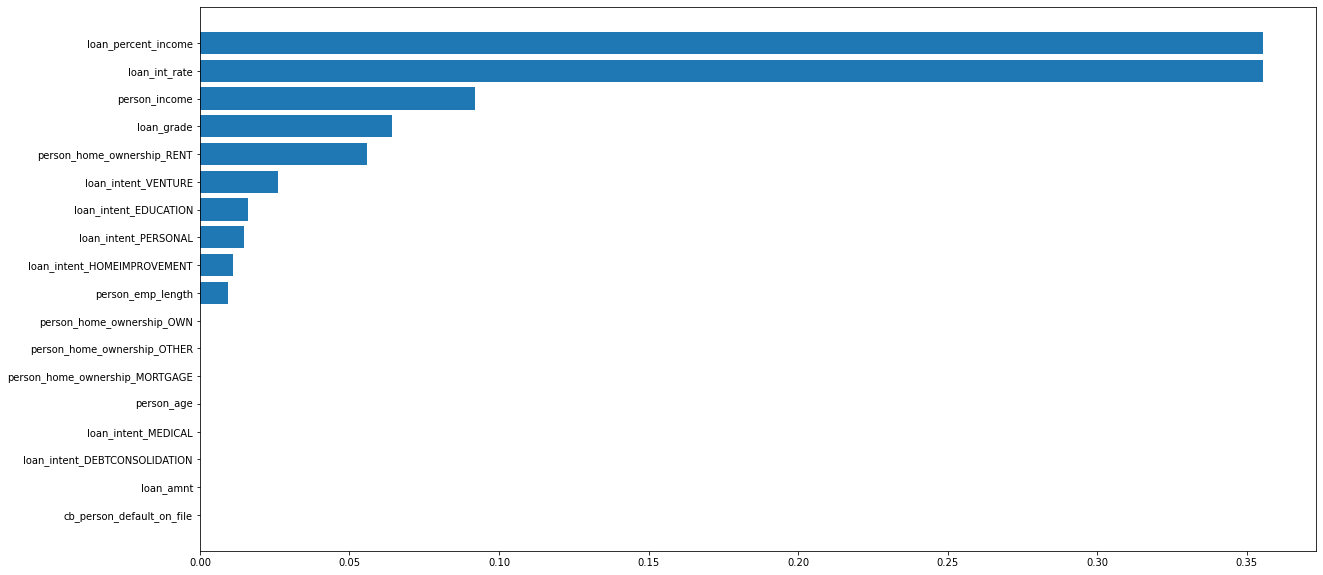

In [88]:
def plot(important):
    f, ax = plt.subplots(figsize=(20,10))
    important_sorted, X.columns_sorted = (list(t) for t in zip(*sorted(zip(list(map(abs, important)), X.columns))))
    plt.barh(X.columns_sorted, important_sorted)
    plt.show()

# Naive Bayes
important = permutation_importance(model_nb, X_test, y_test).importances_mean
plot(important)

# Logistic Regression
important = model_lr.coef_[0]
plot(important)

# Decision Tree
important = model_dt.feature_importances_
plot(important)